In [25]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, SSMCMain.SpaceMMiCRM

In [26]:
using CairoMakie, ProgressLogging
using Base.Threads
using BenchmarkTools
using JLD2, Geppetto
using Random, Distributions

In [27]:
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# ODE/PDE Solving

## Basic no space solve

In [48]:
function random_matrix_initialization(S, M, c_sparsity=1.0, l_sparsity=0.35)
    # 110425 to start let us just randomly draw D and c without structure
    # similarly, we will generate some random guesses for the other parameters

    # constant dilution rate
    rnd = rand()
    r = fill(rnd,M)

    # universal death rate
    rnd2 = rand()
    m = rnd2

    # for simplicity, lets start with a single fed resource
    # chemostat feed rate 
    #K = fill(0.,M)
    #K[1] = 1.

    # lets allow resources some variability
    #K_dist = truncated(Normal(0.5,0.1), 0.0, 1.0)
    K_dist = Beta(0.1,0.3)
    K = rand(K_dist, M)


    # leakage now. Lets assume its a pretty flat probability distribution
    leak = Beta(0.2/l_sparsity,0.2)
    l = rand(leak,(S,M))

    # most values around 0. This is essentially a proxy for sparsity
    c_i_alpha = Beta(0.5/c_sparsity,0.5)
    c = rand(c_i_alpha,(S,M))
    
    # finally, the most complicated distribution
    D = fill(0.,(S,M,M))
    for i in 1:S
        for j in 1:M
            if c[i,j] > 0
                flag = true
                while flag
                    for k in 1:M
                        if j == k
                            D[i,k,j] = 0.0
                        else
                            D[i,k,j] = rand(Beta(0.5/(M/5),0.5))
                        end
                    end
                    # check if the sum of the row is less than 1
                    if sum(D[i,:,j]) < 1.0
                        flag = false
                    end
                end
            end

        end
    end


    Ds = fill(0.,(S+M))
    Ds[1:S] .= 1e-5
    Ds[1+S] = 100
    Ds[S+2:S+M] .= 10

    return r, m, K, l, c, D, Ds

   
    

end

random_matrix_initialization (generic function with 3 methods)

In [ ]:
function marsland_initialization(S, M, c_sparsity=1.0, l_sparsity=0.35)
    # 110425 to start let us just randomly draw D and c without structure
    # similarly, we will generate some random guesses for the other parameters

    # constant dilution rate
    rnd = rand()
    r = fill(rnd,M)

    # universal death rate
    rnd2 = rand()
    m = rnd2

    # for simplicity, lets start with a single fed resource
    # chemostat feed rate 
    #K = fill(0.,M)
    #K[1] = 1.

    # lets allow resources some variability
    #K_dist = truncated(Normal(0.5,0.1), 0.0, 1.0)
    K_dist = Beta(0.1,0.3)
    K = rand(K_dist, M)


    # leakage now. Lets assume its a pretty flat probability distribution
    leak = Beta(0.2/l_sparsity,0.2)
    l = rand(leak,(S,M))

    # most values around 0. This is essentially a proxy for sparsity
    c_i_alpha = Beta(0.1/c_sparsity,0.1)
    c = rand(c_i_alpha,(S,M))
    
    # finally, the most complicated distribution
    D = fill(0.,(S,M,M))
    for i in 1:S
        for j in 1:M
            if c[i,j] > 0
                flag = true
                while flag
                    for k in 1:M
                        if j == k
                            D[i,k,j] = 0.0
                        else
                            D[i,k,j] = rand(Beta(0.5/(M/5),0.5))
                        end
                    end
                    # check if the sum of the row is less than 1
                    if sum(D[i,:,j]) < 1.0
                        flag = false
                    end
                end
            end

        end
    end


    Ds = fill(0.,(S+M))
    Ds[1:S] .= 1e-5
    Ds[1+S] = 100
    Ds[S+2:S+M] .= 10

    return r, m, K, l, c, D, Ds

   
    

end

In [29]:
function distribution_test(S,sparsity)
    # This is simply a test to see if A) I can write a function and B) call it to draw from a distribution

    # define the distribution
    d = Beta(0.1, 0.3)

    # draw a sample of size S   
    sample = rand(d, (S,S))
    
    # return the sample
    return sample

end

distribution_test (generic function with 1 method)

0.2503929553152753
0.13405502859515678


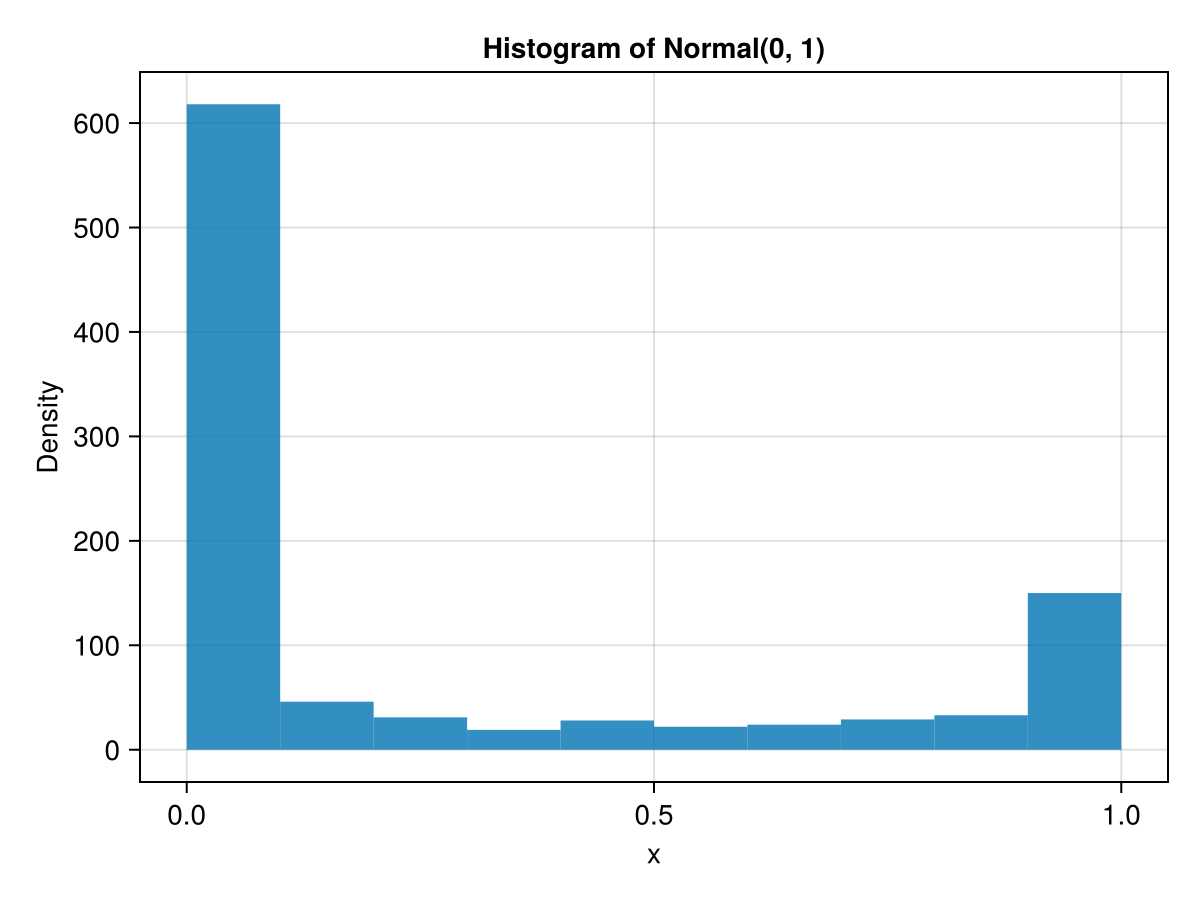

In [30]:
sample = distribution_test(1000,2)
# check the mean and variance
println(mean(sample))
println(var(sample))
# check the histogram with CairoMakie
f = Figure()
ax = Axis(f[1, 1], title="Histogram of Normal(0, 1)", xlabel="x", ylabel="Density")
hist!(ax,sample[1,:], bins=10)
f

In [31]:
#=
# Let's start with basic "CoSMO"

#first define the number of Species and Resources
#number of species
S = 2
#number of resources
M = 3

# resource conversion matrix
D = fill(0., S, M, M)
D[1, 2, 1] = 1.
D[2, 3, 1] = 1.

# consumption matrix
c = fill(0., S, M)
c[1,1] = 1.
c[2,1] = 1.
c[1,3] = 1.
c[2,2] = 1.

# leakage fraction matrix
l = fill(0., S, M)
l[1,1] = 1.
l[2,1] = 1.

# chemostat feed rate 
K = fill(0.,M)
K[1] = 1.

# constant dilution rate
r = fill(0.3,M)

# universal death rate
m = 0.3
=#



In [32]:
# initialize the parameters
S = 20
M = 20
r, m, K, l, c, D, Ds = random_matrix_initialization(S,M)

([0.5896792298879602, 0.5896792298879602, 0.5896792298879602, 0.5896792298879602, 0.5896792298879602, 0.5896792298879602, 0.5896792298879602, 0.5896792298879602, 0.5896792298879602, 0.5896792298879602, 0.5896792298879602, 0.5896792298879602, 0.5896792298879602, 0.5896792298879602, 0.5896792298879602, 0.5896792298879602, 0.5896792298879602, 0.5896792298879602, 0.5896792298879602, 0.5896792298879602], 0.9602150947077916, [1.2707947563181381e-5, 0.0005316320263925096, 7.414021128896226e-5, 3.668833789581723e-12, 2.350426162076628e-8, 7.675237852281763e-6, 0.9980534083398837, 2.081932495752562e-17, 0.0016730323222994626, 0.9359347477446881, 0.6629787610237787, 0.001281900836054317, 0.4278396305522457, 0.6768408319923555, 0.03533436711678006, 0.16655950250421248, 0.019414869242307457, 5.3753423188680494e-5, 5.570257062290044e-12, 0.0032792750477081594], [0.9511262885166323 0.9948022618583318 … 0.9999994192827459 0.9884117745663313; 0.117620948018924 0.9999801512173817 … 0.999064183511539 0.

┌ Info: strain 1 leaks less than it energetically can through consuming 1
└ @ SSMCMain.ModifiedMiCRM /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/ModifiedMiCRM/ModifiedMiCRM.jl:72
┌ Info: strain 1 leaks less than it energetically can through consuming 2
└ @ SSMCMain.ModifiedMiCRM /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/ModifiedMiCRM/ModifiedMiCRM.jl:72
┌ Info: strain 1 leaks less than it energetically can through consuming 3
└ @ SSMCMain.ModifiedMiCRM /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/ModifiedMiCRM/ModifiedMiCRM.jl:72
┌ Info: strain 1 leaks less than it energetically can through consuming 4
└ @ SSMCMain.ModifiedMiCRM /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/ModifiedMiCRM/ModifiedMiCRM.jl:72
┌ Info: strain 1 leaks less than it energetically can through consuming 5
└ @ SSMCMain.ModifiedMiCRM /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/ModifiedMiCRM/ModifiedMiCRM.jl:72
┌ Info: strain 1 leaks less than it

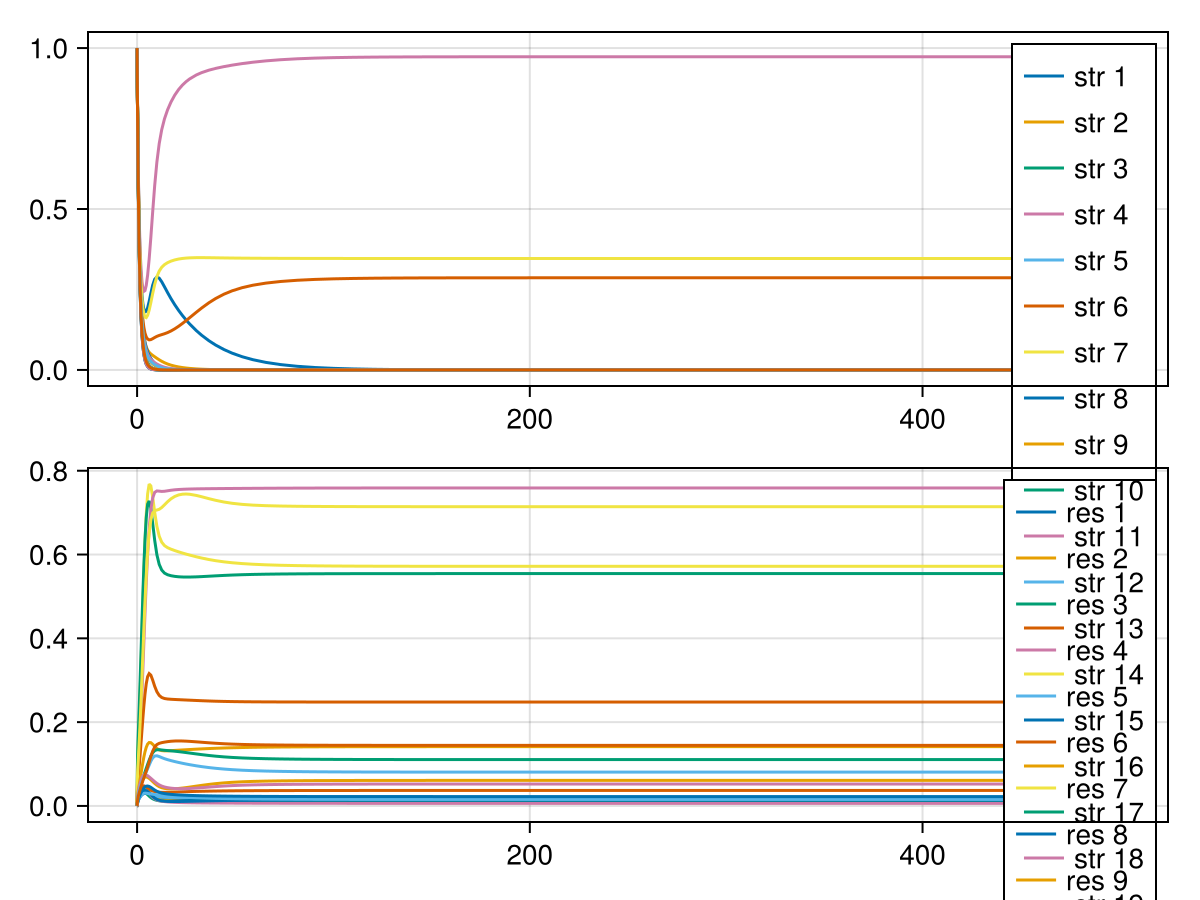

40-element Vector{Float64}:
  4.7068706581126836e-9
  1.1129926985073517e-20
 -2.1765125198388078e-34
  0.9730945609137818
 -4.264506501661385e-33
  1.6245072546554214e-32
 -2.5403786297067177e-33
 -2.932482882039454e-24
 -4.9614186315082376e-33
 -9.433813686309036e-34
  ⋮
  0.015413123461179594
  0.24785902468487364
  0.7141276926707404
  0.02220942645442775
  0.1414194990136732
  0.11057789578882954
  0.0522604824152405
  0.0806629680075311
  0.14448814070628122

In [33]:

p = make_mmicrm_smart(S, M, 500;
    D, c, l,
    K,r,m,
    u0=:onlyN,
    u0rand=0.
)
s = solve(p)
check_mmicrmparams(p.p)
display(plot_mmicrm_sol(s))
s[end]
#param_summary(p.p)

## Linear stability analysis

In [34]:
usol = s[end]
show(uninplace(mmicrmfunc!)(usol, p.p, 0))

[-2.1184529390838712e-10, -1.4571518519552614e-21, 1.571107739745853e-34, 1.220999770751812e-10, 3.263674563599057e-33, -9.962763670471997e-33, 1.696777691416426e-33, 1.1899404451158281e-24, 3.813073088806353e-33, 6.142771122437004e-34, 6.289056972727341e-25, -2.175950156186939e-31, 1.429373401642622e-10, -7.152455355313113e-12, 2.1140117838591763e-33, 9.963519130065664e-29, 3.0810308165383327e-33, 2.9018209930680758e-33, 2.752172593327398e-29, -1.8368566153254166e-31, -3.3244761110662324e-12, -3.47648992926608e-12, 1.6976454964012788e-12, -2.5768363137723682e-12, 1.5995087199183189e-12, 3.4827488115674043e-12, -3.1474224268523976e-11, 3.1327614113951796e-12, 1.377013780778924e-11, 1.1948570605158082e-11, 7.481973374190432e-12, -7.490312189939452e-12, -2.9640248588869156e-12, -1.6428153976066895e-11, -3.96044308459409e-12, 1.0617347279140432e-11, -1.8317417027624572e-11, 1.218503076216848e-11, -2.1820129036953517e-11, -9.355932695243041e-12]

maximum(real(lambdas)) = -0.0005409153668305567
stable :(


┌ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.431979
└ @ SSMCMain /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/util.jl:177
┌ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.431979
└ @ SSMCMain /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/util.jl:177
┌ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.414429
└ @ SSMCMain /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/util.jl:177
┌ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.347324
└ @ SSMCMain /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/util.jl:177
┌ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.314030
└ @ SSMCMain /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/util.jl:177
┌ Info: we are getting non-zero imaginary parts, max(abs(.)) is 0.135522
└ @ SSMCMain /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/util.jl:177
┌ Info: we are getting non-zero imaginary parts, max(abs(.)) is 

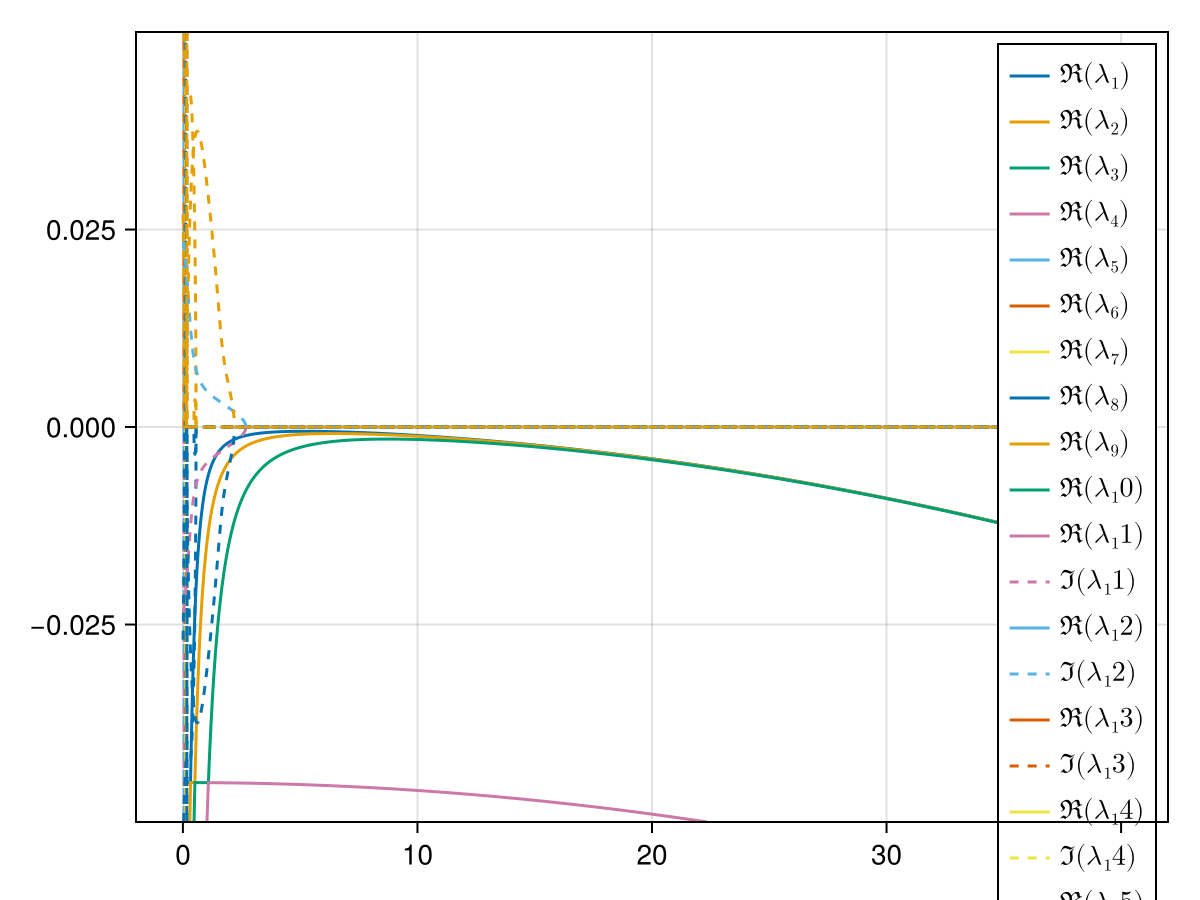

In [35]:
ks = LinRange(0., 40., 10000)
#Ds = [1e-5,1e-5, 500, 10, 10]

lambdas = do_linstab_for_ks(ks, p, Ds, usol);
@show maximum(real(lambdas))
if maximum(real(lambdas)) > 0
    println("unstable!")
else
    println("stable :(")
end
# plot the eigenvalues
faa = plot_linstab_lambdas(ks, lambdas[:,:])
ylims!(faa.axis, (-0.05, 0.05))
# xlims!(faa.axis, (0., 2.))
faa

In [36]:
# Finds the k with the biggest maximum eigenvalue
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax

(1301, 5.200520052005201)

In [37]:
ff = linstab_make_full_func(p.p, usol, Ds)
kmax_es = ff(kmax)
kmax_es.vectors[:,1] # the eigensystem is sorted by evalue so this is the one

40-element Vector{Float64}:
  7.678795901755043e-11
 -1.5287476058004548e-14
 -1.1569115698117492e-15
 -0.1531526255524264
 -1.5821030496608528e-15
  1.7433734802405055e-15
 -2.394325053660124e-15
  1.9133839300778204e-14
 -2.1801901232078654e-15
 -9.060113871306316e-15
  ⋮
 -5.50912650394116e-6
  7.307279116008911e-5
  0.0013419983638799733
 -9.909855921442162e-6
 -1.1861901245853124e-5
  0.00015384317984630617
 -0.000351784453005699
 -0.00014414240582337134
  0.00013833782015640502

## Probability of instability!

In [38]:
# We are going to run a set of replicates to see how probable instability is
nrep = 100

S = 20
M = 20  

instability = fill(0., nrep)

for ii in 1:nrep
    # initialize the parameters
    r, m, K, l, c, D, Ds = random_matrix_initialization(S,M)

    # create the model
    p = make_mmicrm_smart(S, M, 500;
        D, c, l,
        K,r,m,
        u0=:onlyN,
        u0rand=0.
    )
    s = solve(p)

    usol = s[end]

    # check the stability
    ks = LinRange(0., 40., 10000)
    lambdas = do_linstab_for_ks(ks, p, Ds, usol);

    if maximum(real(lambdas)) > 0
        instability[ii] = 1.
    else
        instability[ii] = 0.
    end
    #println("replicate ", ii, " of ", nrep, " done")
end

println("fraction instability: ", sum(instability)/nrep)


fraction instability: 0.14


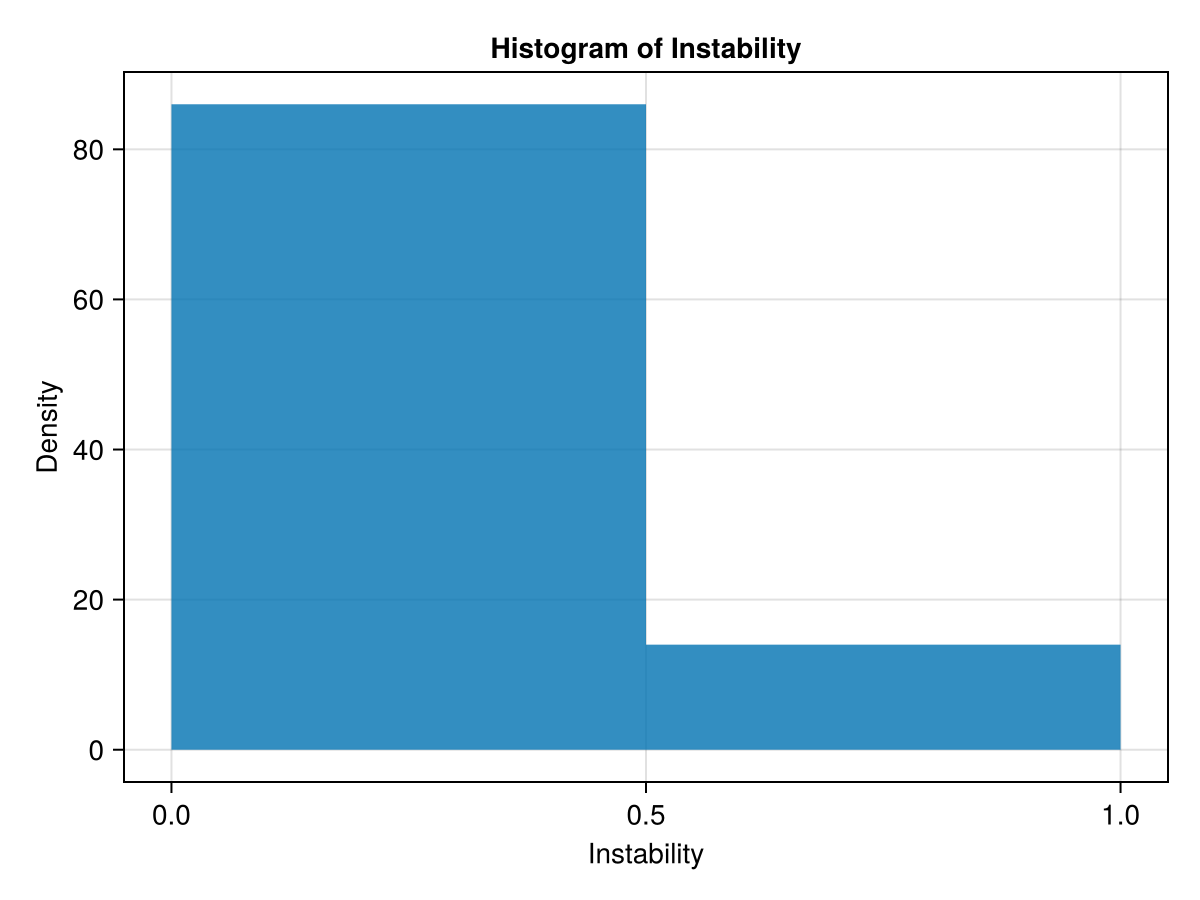

In [39]:
# check the histogram of instability
f = Figure()
ax = Axis(f[1, 1], title="Histogram of Instability", xlabel="Instability", ylabel="Density")
hist!(ax, instability, bins=2)#, normalization = :pdf)
f

In [43]:
# Now we'll see % instability as a function of size

species = [2, 5, 10, 15, 20]
nspecies = length(species)

perc_instability = fill(0., nspecies)


for x in 1:nspecies

    println(x)
    nrep = 100

    S = species[x]
    M = species[x]

    println(S, " species")
    println(M, " resources")

    instability = fill(0., nrep)

    for ii in 1:nrep
        # initialize the parameters
        r, m, K, l, c, D, Ds = random_matrix_initialization(S,M)

        # create the model
        p = make_mmicrm_smart(S, M, 500;
            D, c, l,
            K,r,m,
            u0=:onlyN,
            u0rand=0.
        )
        s = solve(p)

        usol = s[end]

        # check the stability
        ks = LinRange(0., 40., 10000)
        lambdas = do_linstab_for_ks(ks, p, Ds, usol);

        if maximum(real(lambdas)) > 0
            instability[ii] = 1.
        else
            instability[ii] = 0.
        end
        #println("replicate ", ii, " of ", nrep, " done")
    end
    println("finished replicates for ", S, " species")

    println("fraction instability: ", sum(instability)/nrep)
    perc_instability[x] = sum(instability)/nrep
end

1
2 species
2 resources
finished replicates for 2 species
fraction instability: 0.03
2
5 species
5 resources
finished replicates for 5 species
fraction instability: 0.02
3
10 species
10 resources
finished replicates for 10 species
fraction instability: 0.08
4
15 species
15 resources
finished replicates for 15 species
fraction instability: 0.05
5
20 species
20 resources
finished replicates for 20 species
fraction instability: 0.09


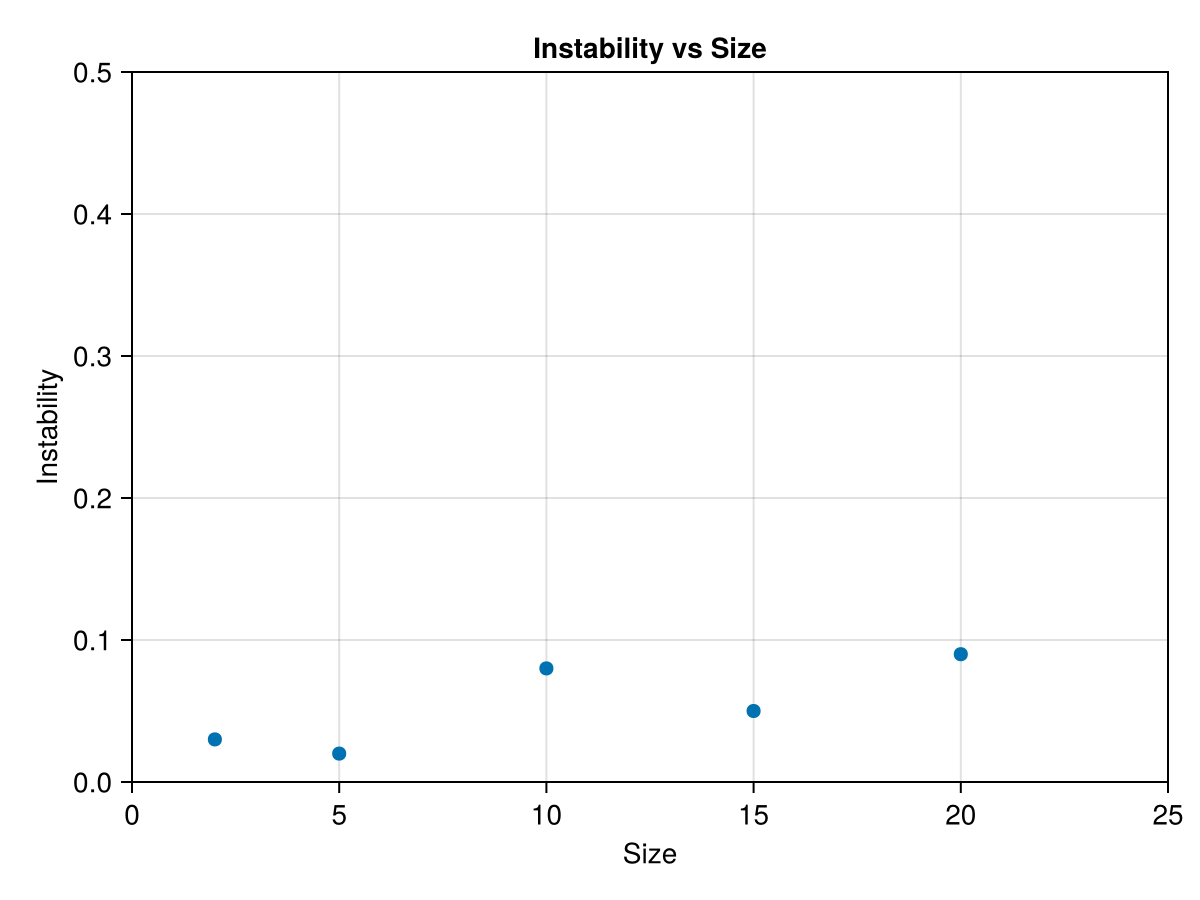

In [45]:
# plot the results
f = Figure()
ax = Axis(f[1, 1], title="Instability vs Size", xlabel="Size", ylabel="Instability")
scatter!(ax, species, perc_instability, markersize=10)
ylims!(ax, (0., 0.5))
xlims!(ax, (0., 25.))
f

In [55]:
# now let's see how the instability changes with sparsity and average leakage

nc = 5
nl = 5

repeats = 3
nrep = 20

instability = fill(0., (nc,nl,repeats,nrep))

for i in 1:nc
    c_sparsity = i/nc
    for j in 1:nl
        l_sparsity = j/nl
        for k in 1:repeats
            for q in 1:nrep
          
                # initialize the parameters
                S = 10
                M = 10

                r, m, K, l, c, D, Ds = random_matrix_initialization(S,M,c_sparsity,l_sparsity)

                # create the model
                p = make_mmicrm_smart(S, M, 500;
                    D, c, l,
                    K,r,m,
                    u0=:onlyN,
                    u0rand=0.
                )
                s = solve(p)
                usol = s[end]
                # check the stability
                ks = LinRange(0., 40., 10000)
                lambdas = do_linstab_for_ks(ks, p, Ds, usol)
                if maximum(real(lambdas)) > 0
                    instability[i,j,k,q] = 1.
                else
                    instability[i,j,k,q] = 0.
                end
                #println("replicate ", ii, " of ", nrep, " done")
            end
        end
    
    end
end



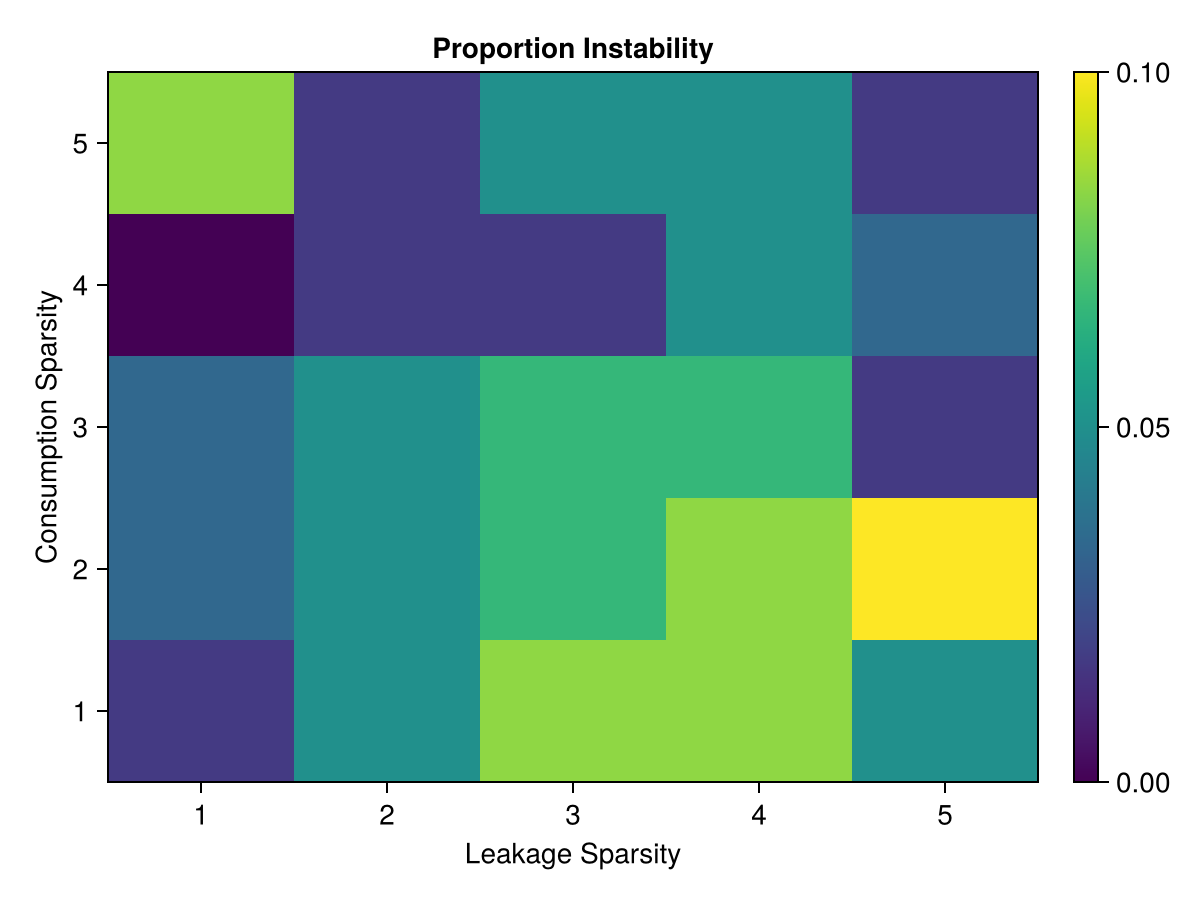

In [57]:
# lets plot the heatmap

# first we need to average over the repeats
instability_avg = fill(0., (nc,nl))
for i in 1:nc
    for j in 1:nl
        instability_avg[i,j] = sum(instability[i,j,:,:])/(repeats*nrep)
    end
end

# now we can plot the heatmap
fig, ax, hm = heatmap(instability_avg, colormap = :viridis, axis = (title = "Proportion Instability", xlabel = "Leakage Sparsity", ylabel = "Consumption Sparsity"))
Colorbar(fig[:, end+1], hm)
fig



## Spatial stuff - 1D!

In [88]:
ssize = (1000,)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.1, 0.1)
space = make_cartesianspace_smart(length(ssize); dx=0.01, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 10000000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((40, 1000), 1, CartesianSpace{1, Tuple{Periodic}, Float64}([0.01]))

#### Direct solver

In [89]:
@time sps = solve(sp, QNDF(); maxiters=1000)
print_spatial_solution_stats(sps)

 46.710585 seconds (29.09 M allocations: 12.288 GiB, 28.28% gc time, 27.83% compilation time)
Success
nf is 1065
solution has 206 saved states
max resid is 9.65108e-09


┌ Warning: reaching negative values, minimum is -4.33897e-06
└ @ SSMCMain.SpaceMMiCRM /Users/stevenredford/Dropbox/Python/SSMC/src/SSMCMain/src/ModifiedMiCRM/smmicrm_util.jl:10


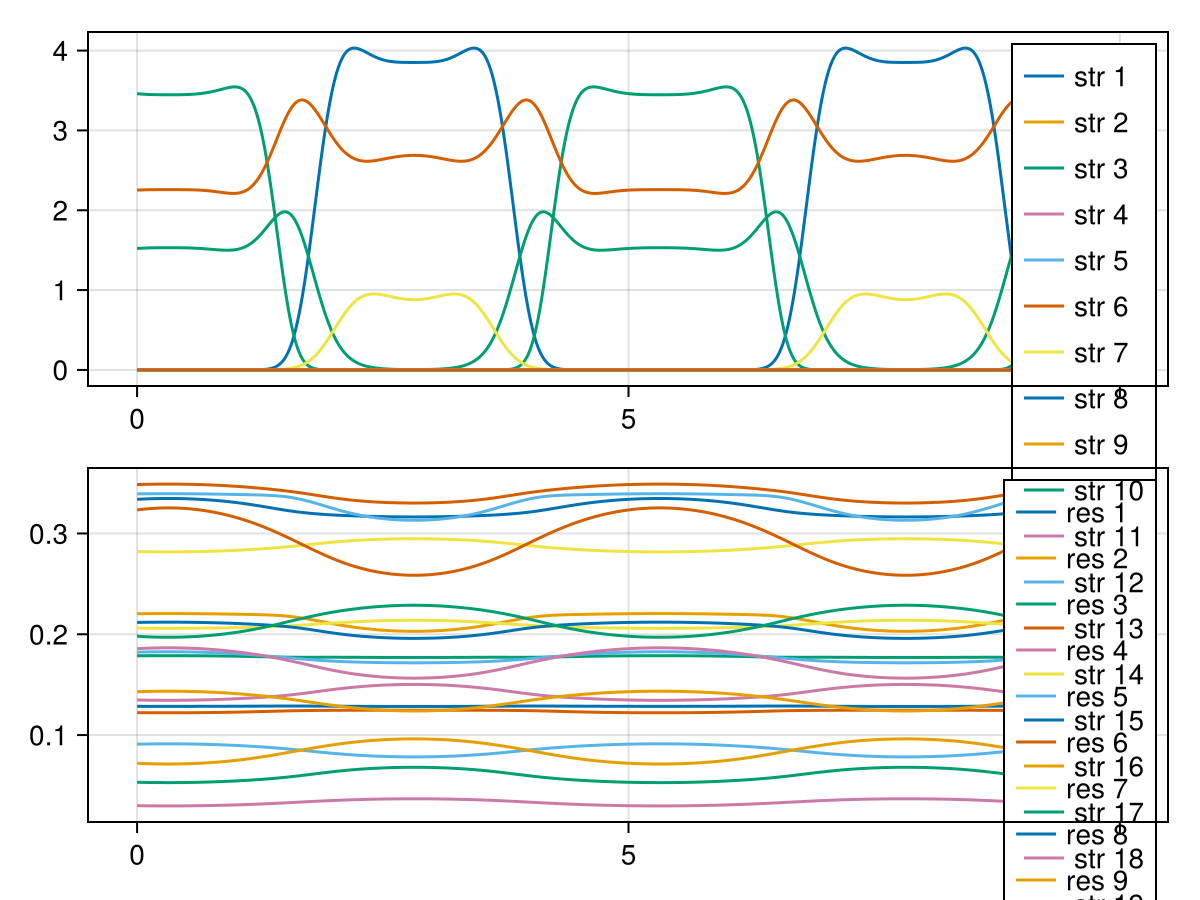

In [90]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps(sps.t[end]))

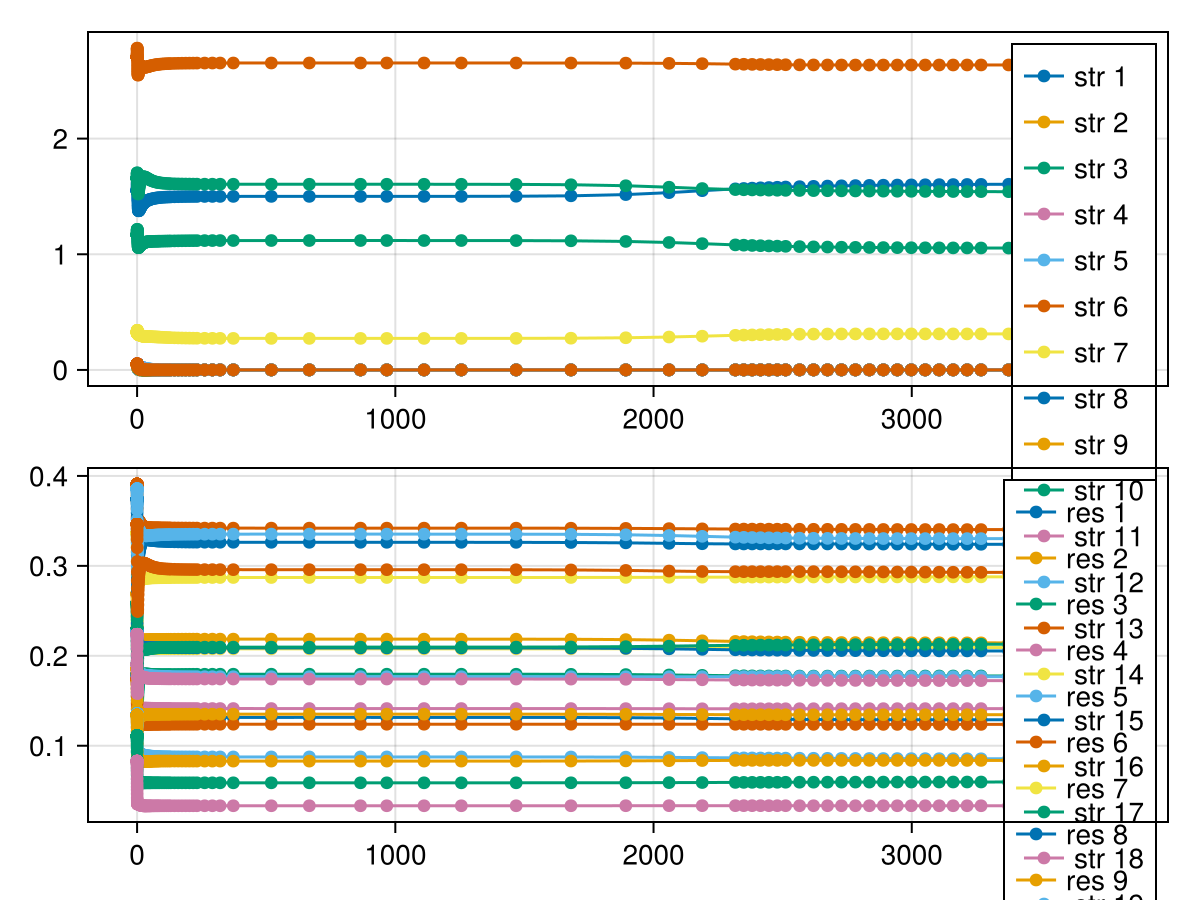

In [91]:
plot_smmicrm_sol_avgs(sps, 1:170)

#### Steady state solver

ReturnCode.Success = 1

1656

  2.612578 seconds (10.12 M allocations: 1012.315 MiB, 10.17% gc time, 77.99% compilation time)


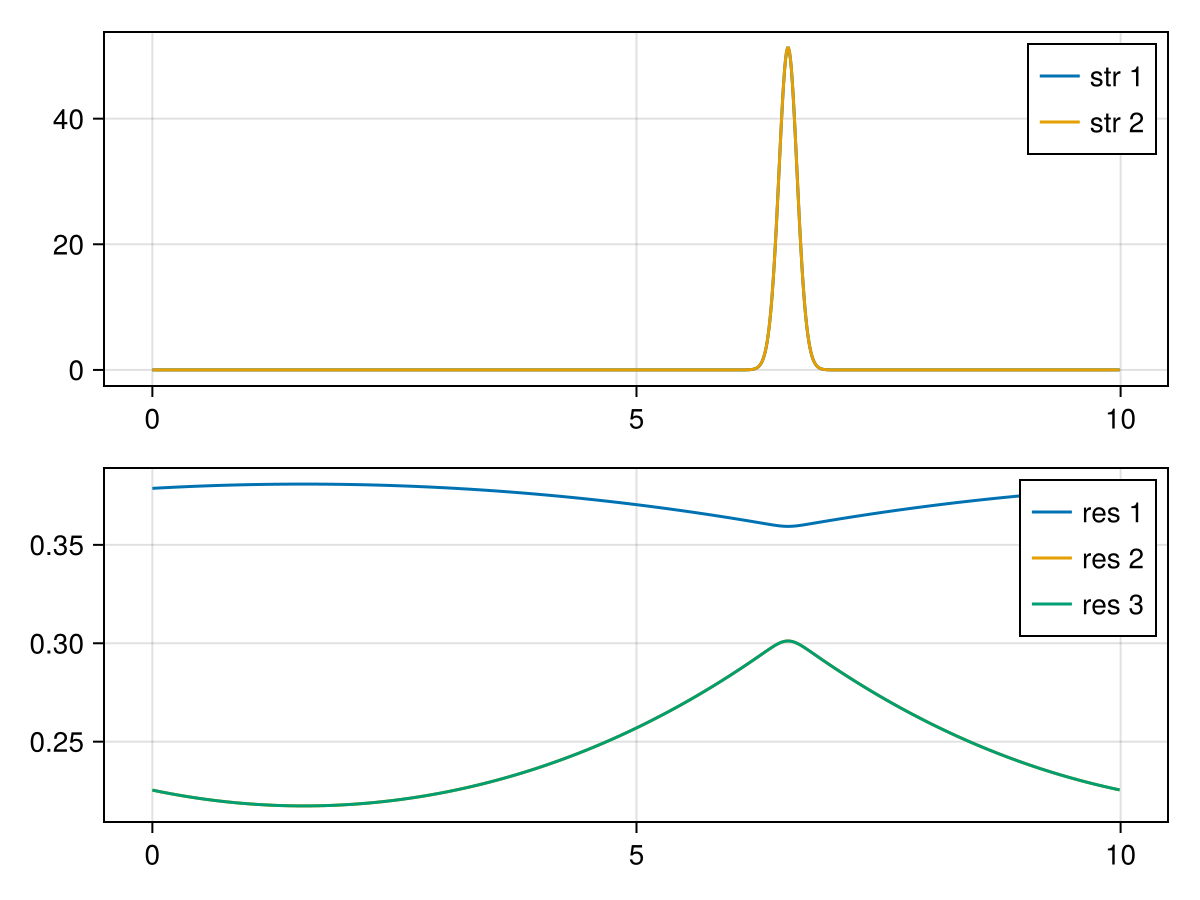

In [35]:
sssp = SteadyStateProblem(sp)
@time sssps = solve(sssp, DynamicSS(QNDF()); maxiters=1000)
display(sssps.retcode)
display(sssps.original.destats.nf)
plot_1dsmmicrm_sol_snap(sssps.prob.p, sssps.u)

## Spatial stuff - 2D!

In [92]:
ssize = (60,60)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.1, 0.1)
space = make_cartesianspace_smart(length(ssize); dx=0.1, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 100000000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((40, 60, 60), 1, CartesianSpace{2, Tuple{Periodic, Periodic}, Float64}([0.1, 0.1]))

#### Direct solver

In [ ]:
@time sps = solve(sp, QNDF(); maxiters=10000)
print_spatial_solution_stats(sps)

In [ ]:
sps.prob.p

In [ ]:
f = plot_2dsmmicrm_sol_snap_heatmap(sps, -1)

In [11]:
f = plot_smmicrm_sol_avgs(sps; plote=true)
display(GLMakie.Screen(), f)

GLMakie.Screen(...)

In [12]:
f = plot_2dsmmicrm_sol_interactive_heatmap(sps)
display(GLMakie.Screen(), f)

GLMakie.Screen(...)

## Saving/loading

In [61]:
save_object(datadir("minimalmodel", randname()*".jld2"), sps)

In [9]:
sps = load_object("../data/minimalmodel/fascinating_maybe_moving.jld2");
print_spatial_solution_stats(sps)

MaxIters
nf is 110126
solution has 8608 saved states
max resid is 0.00431203


# Symbolics

In [5]:
using Symbolics, SymbolicsMathLink
import Nemo


Welcome to Nemo version 0.48.4

Nemo comes with absolutely no warranty whatsoever


In [6]:
function mycoeff(exp, var, power)
    s = Num(0)
    for t in Symbolics.terms(exp)
        if Symbolics.degree(t, var) == power
            s += t / (var^power)
        end
    end
    s
    # sum(filter(t->Symbolics.degree(t, var)==power, Symbolics.terms(exp)))
end

mycoeff (generic function with 1 method)

In [7]:
pvars = @variables m l K c d
fvars = @variables N G R
ssvars = @variables N_ss G_ss R_ss
Dvars = @variables D_N D_G D_R
@variables k;

In [8]:
sym_params = MMiCRMParams(
    Num.(p.p.g), Num.(p.p.w),
    SA[m],
    SA[K, 0.], Num.(SA[1., 1.]),
    SA[l 0.], SA[c d], Num.(p.p.D)
)
u = SA[N, G, R]
eqs = uninplace(mmicrmfunc!)(u, sym_params)

3-element SizedVector{3, Num, Vector{Num}} with indices SOneTo(3):
 (-m + R*d + G*c*(1.0 - l))*N
               -G + K - G*N*c
         -R - N*R*d + G*N*c*l

#### Analytic expressions for mixed (no space) steady states and their stability

express G and R in terms of N and then get a quadratic equation in N **ONLY VALID IF N IS NOT 0**

In [20]:
mR = symbolic_solve((eqs[1]/N)~0, R)[1]
mG = symbolic_solve(eqs[2]~0, G)[1]
display(R==mR)
display(G==mG)
feq = simplify(substitute(substitute(eqs[3], R=>mR), G=>mG)*(-d*(1+N*c)))
display(feq==0)

R == ((-m + G*c - G*c*l) / (-d))

G == (K / (1 + N*c))

(m - K*c + K*c*l + N*c*m + N*d*m - K*N*c*d + (N^2)*c*d*m) == 0

##### alternate expression for R that is valid even when N is 0, aka N=0 => R=0

In [21]:
mR2 = symbolic_solve(eqs[3]~0, R)[1]
display(Symbolics.variable(:R_v2)==mR2)

R_v2 == ((G*N*c*l) / (1 + N*d))

##### Interpretable solution?

In [22]:
c, b, a = mycoeff.(feq, N, 0:2)
display([a, b, c])
D = b^2 - 4*a*c

3-element Vector{Num}:
             c*d*m
 c*m + d*m - K*c*d
   m - K*c + K*c*l

(c*m + d*m - K*c*d)^2 - 4(m - K*c + K*c*l)*c*d*m

In [23]:
display(expand(D))
display(wcall("Simplify", wcall("Expand", D)))
display(wcall("FullSimplify", wcall("Expand", D)))
display(wcall("FullSimplify", D))
sD = wcall("FullSimplify", D);

(c^2)*(m^2) - (2//1)*c*d*(m^2) + (d^2)*(m^2) + (2//1)*K*(c^2)*d*m - (2//1)*K*c*(d^2)*m + (K^2)*(c^2)*(d^2) - (4//1)*K*(c^2)*d*l*m

(d^2)*(m^2) - 2(m + K*d)*c*d*m + (m^2 + (K^2)*(d^2) + 2K*d*(1 - 2l)*m)*(c^2)

((c - d)^2)*(m^2) + (K^2)*(c^2)*(d^2) - 2K*c*(d + c*(-1 + 2l))*d*m

((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m

In [24]:
N1 = simplify((-b+sqrt(sD))/(2*a))

(sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m - d*m + K*c*d) / (2c*d*m)

##### Naively plugging this into forms for M1 and M (kinda pointless)

In [25]:
G1 = simplify(Num(substitute(mG, N=>N1)))
R1 = simplify(Num(substitute(mR, G=>G1)))
mssol1 = [N1, G1, R1]

3-element Vector{Num}:
                                                                                                            (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m - d*m + K*c*d) / (2c*d*m)
                                                                                                            (2K*d*m) / (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m + d*m + K*c*d)
 (-m*sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) + c*(m^2) - d*(m^2) + K*c*d*m - (2//1)*K*c*d*l*m) / ((-sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) + c*m - d*m - K*c*d)*d)

In [236]:
make_M1(sym_params, mssol1)

3×3 Matrix{Num}:
 -m + (-m*sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) + c*(m^2) - d*(m^2) + K*c*d*m - (2//1)*K*c*d*l*m) / (-sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) + c*m - d*m - K*c*d) + (2K*c*d*(1 - l)*m) / (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m + d*m + K*c*d)  …          (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m - d*m + K*c*d) / (2c*m)
                                                                                                                                                                                                              -((2K*c*d*m) / (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m + d*m + K*c*d))                                                                                                 0.0
             (2K*c*d*l*m) / (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m + d*m + K*c*d) + (m*sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*(m^2) + 

In [26]:
make_M1(sym_params, mssol1)

3×3 Matrix{Num}:
 -m + (-m*sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) + c*(m^2) - d*(m^2) + K*c*d*m - (2//1)*K*c*d*l*m) / (-sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) + c*m - d*m - K*c*d) + (2K*c*d*(1 - l)*m) / (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m + d*m + K*c*d)  …          (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m - d*m + K*c*d) / (2c*m)
                                                                                                                                                                                                              -((2K*c*d*m) / (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m + d*m + K*c*d))                                                                                                 0.0
             (2K*c*d*l*m) / (sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*m + d*m + K*c*d) + (m*sqrt(((-c - d)*m + K*c*d)^2 - 4(m + K*c*(-1 + l))*c*d*m) - c*(m^2) + 

#### Ms with general/symbolic ss sol

In [24]:
symM1 = make_M1(sym_params, ssvars)

3×3 Matrix{Num}:
 -m + R_ss*d + G_ss*c*(1 - l)  N_ss*c*(1 - l)         N_ss*d
                      -G_ss*c   -1.0 - N_ss*c            0.0
           -R_ss*d + G_ss*c*l        N_ss*c*l  -1.0 - N_ss*d

In [25]:
export_expr_to_wolfram(symM1, datadir("minimalmodel", "ssymM1"))

In [23]:
symM = make_M(symM1, k, Dvars)

3×3 Matrix{Num}:
 -m + R_ss*d - D_N*(k^2) + G_ss*c*(1 - l)  …                     N_ss*d
                                  -G_ss*c                           0.0
                       -R_ss*d + G_ss*c*l     -1.0 - N_ss*d - D_R*(k^2)

In [199]:
export_expr_to_wolfram(symM, datadir(randname()))

#### Ms for the non-extinct solution where we keep only N_ss symbolic

In [33]:
mGss = substitute(mG, N=>ssvars[1])
mRss = substitute(mR2, [G=>mGss, N=>ssvars[1]])
display(mGss)
display(mRss)

K / (1 + N_ss*c)

(K*N_ss*c*l) / ((1 + N_ss*c)*(1 + N_ss*d))

In [45]:
simplify(make_M1(sym_params, [ssvars[1], mGss, mRss]))

3×3 Matrix{Num}:
 -m + (K*c*(1 - l)) / (1 + N_ss*c) + (K*N_ss*c*d*l) / ((1 + N_ss*c)*(1 + N_ss*d))  …  N_ss*c*(1 - l)         N_ss*d
                                                          -((K*c) / (1 + N_ss*c))      -1.0 - N_ss*c            0.0
           (K*c*l) / (1 + N_ss*c) + (-K*N_ss*c*d*l) / ((1 + N_ss*c)*(1 + N_ss*d))           N_ss*c*l  -1.0 - N_ss*d

#### More bits

##### Making the K polynomial

In [325]:
@variables a b c d e f g h i o p q K;
M = [a - o*K b c; d e - p*K f; g h i - q*K]
display(M)
detM = det(M)
edetM = expand(detM)

3×3 Matrix{Num}:
 a - K*o        b        c
       d  e - K*p        f
       g        h  i - K*q

a*e*i - a*f*h - b*d*i + b*f*g + c*d*h - c*e*g - K*a*e*q - K*a*i*p + K*b*d*q + K*c*g*p - K*e*i*o + K*f*h*o + (K^2)*a*p*q + (K^2)*e*o*q + (K^2)*i*o*p - (K^3)*o*p*q

In [326]:
Kcoeffs = mycoeff.(edetM, K, 0:3)

4-element Vector{Num}:
  a*e*i - a*f*h - b*d*i + b*f*g + c*d*h - c*e*g
 -a*e*q - a*i*p + b*d*q + c*g*p - e*i*o + f*h*o
                          a*p*q + e*o*q + i*o*p
                                         -o*p*q

In [327]:
simplify(expand(sum(Kcoeffs .* K.^(0:3))) == edetM)

true

In [328]:
string.(Kcoeffs)

4-element Vector{String}:
 "a*e*i - a*f*h - b*d*i + b*f*g + c*d*h - c*e*g"
 "-a*e*q - a*i*p + b*d*q + c*g*p - e*i*o + f*h*o"
 "a*p*q + e*o*q + i*o*p"
 "-o*p*q"

In [329]:
@variables a b c d e f g h i o p q K l;
fM = [a - o*K - l b c; d e - p*K - l f; g h i - q*K - l]
display(fM)
detfM = det(fM)
# simplify(detfM)
edetfM = expand(detfM)

3×3 Matrix{Num}:
 a - l - K*o            b            c
           d  e - l - K*p            f
           g            h  i - l - K*q

a*e*i - a*e*l - a*f*h - a*i*l + a*(l^2) - b*d*i + b*d*l + b*f*g + c*d*h - c*e*g + c*g*l - e*i*l + e*(l^2) + f*h*l + i*(l^2) - (l^3) - K*a*e*q - K*a*i*p + K*a*l*p + K*a*l*q + K*b*d*q + K*c*g*p - K*e*i*o + K*e*l*o + K*e*l*q + K*f*h*o + K*i*l*o + K*i*l*p - K*(l^2)*o - K*(l^2)*p - K*(l^2)*q + (K^2)*a*p*q + (K^2)*e*o*q + (K^2)*i*o*p - (K^2)*l*o*p - (K^2)*l*o*q - (K^2)*l*p*q - (K^3)*o*p*q

In [324]:
mycoeff.(edetfM, l, 0:3)

4-element Vector{Num}:
 a*e*i - a*f*h - b*d*i + b*f*g + c*d*h - c*e*g - K*a*e*q - K*a*i*p + K*b*d*q + K*c*g*p - K*e*i*o + K*f*h*o + (K^2)*a*p*q + (K^2)*e*o*q + (K^2)*i*o*p - (K^3)*o*p*q
                                            -a*e - a*i + b*d + c*g - e*i + f*h + K*a*p + K*a*q + K*e*o + K*e*q + K*i*o + K*i*p - (K^2)*o*p - (K^2)*o*q - (K^2)*p*q
                                                                                                                                       a + e + i - K*o - K*p - K*q
                                                                                                                                                                -1

# Extras

In [952]:
GC.gc()
empty!(Out)

Dict{Int64, Any}()